#Introducction

In this notebook, I will try  to apply tools to predict and complete a data set using models of classifications.

The data obtained from a cellular accelerometer contain X, Y and Z as accelerate direction, the date of the sample, the timestamp of the sample and some labels.

>Key tasks:

1.   Accommodate the data for an easy handle.
1.   Check the data to search null samples.
1.   Select a  classification model with cross validation method. 
1.   Use the classifier for predicting with the test data.
1.   Save the result as CSV and concluding.

>Data explanation.

We have tree datasets in CSV format:

Data for training:

1.   **train_labels.CSV**: contains timestamp of sample, date of sample, ID of sample  and the label correspondent. This data only has 375 sample from the train_time_series.CSV.
2.   **train_time_series.CSV**: contains timestamp of sample, date of sample, ID of sample  and the XYZ directions. This data not has the labels of the samples.

Data for testing:

3.   **test_labels.CSV**: contains timestamp of sample, date of sample, ID of sample  and the labels but need to be filled.
4.   **test_time_series.CSV**: contains timestamp of sample, date of sample, ID of sample  and the XYZ directions. This data not has the labels of the samples.

The goal is to make a classification model with the training data and pass it test data for predicting its labels.

The labels are:

      1 = standing (de pie)
      2 = walking
      3 = stairs down
      4 = stairs up. 

#Methods

1- Import dependencies from like pandas, NumPy, Matplotlib and others from sklearn.

In [5]:
#Time calculation start
import time
start_time= time.process_time()

#Dependencies
import pandas as pd
import numpy as np


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
#from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

#import warnings

2- Creating the variables for each data CSV.

In [6]:
#imput data
train_labels=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Python for research - Harvard course/Proyectos/train_labels.csv")
train_time_series=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Python for research - Harvard course/Proyectos/train_time_series.csv")

#test data
test_labels=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Python for research - Harvard course/Proyectos/test_labels.csv")
test_time_series=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Python for research - Harvard course/Proyectos/test_time_series.csv")



##1-Accommodate the data for an easy handle.
Understanding the date 

I made some analysis to the data for my own understanding.

Data I have: 

train time serie:
>  X: horizontal,
>  Y: horizontal,
>  Z: vertical
>
>  timestamp 
>
>  unnamed (ID)
>
>  UTC time
>
train labels:


 > timestamp 
>
 > unnamed (ID)
>
 > UTC time
>
 > labels(1-2-3-4)

In [7]:
train_labels

,Unnamed: 0,timestamp,UTC time,label
0,20589,1565109931087,2019-08-06T16:45:31.087,1
1,20599,1565109932090,2019-08-06T16:45:32.090,1
2,20609,1565109933092,2019-08-06T16:45:33.092,1
3,20619,1565109934094,2019-08-06T16:45:34.094,1
4,20629,1565109935097,2019-08-06T16:45:35.097,1
...,...,...,...,...
370,24289,1565110302030,2019-08-06T16:51:42.030,4
371,24299,1565110303032,2019-08-06T16:51:43.032,4
372,24309,1565110304034,2019-08-06T16:51:44.034,4
373,24319,1565110305037,2019-08-06T16:51:45.037,4


In [8]:
train_time_series

,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
2,20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
3,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
4,20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450
...,...,...,...,...,...,...,...
3739,24325,1565110305638,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304
3740,24326,1565110305738,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213
3741,24327,1565110305838,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713
3742,24328,1565110305939,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805


I compare elements in both data and I see there are similitude in some columns. This mean the samples in training data are the same.

In [9]:
data_time=['Unnamed: 0',"timestamp","UTC time"]

train_time_series[data_time].loc[3] == train_labels[data_time].loc[0]

Unnamed: 0    True
timestamp     True
UTC time      True
dtype: bool

I merge the training data for obtaining a full information dataset using a for loop, and append method of DataFrame.

In [10]:
train_ts_with_label_data= pd.DataFrame()

In [11]:
for i in list(train_labels['Unnamed: 0']):
  train_ts_with_label_data=train_ts_with_label_data.append(train_time_series.loc[train_time_series['Unnamed: 0']==i],ignore_index=True)

I merge the test data with the merge method of pd and save it in **test_data**.

In [12]:
all_covariates=["x","y","z"]

In [13]:
test_data=pd.merge(test_labels,test_time_series[all_covariates],left_index=True, right_index=True)
test_data

,Unnamed: 0,timestamp,UTC time,label,x,y,z
0,24339,1565110307041,2019-08-06T16:51:47.041,NaN,0.034286,-1.504456,0.157623
1,24349,1565110308043,2019-08-06T16:51:48.043,NaN,0.409164,-1.038544,0.030975
2,24359,1565110309046,2019-08-06T16:51:49.046,NaN,-0.234390,-0.984558,0.124771
3,24369,1565110310048,2019-08-06T16:51:50.048,NaN,0.251114,-0.787003,0.054810
4,24379,1565110311050,2019-08-06T16:51:51.050,NaN,0.109924,-0.169510,0.235550
...,...,...,...,...,...,...,...
120,25539,1565110427366,2019-08-06T16:53:47.366,NaN,0.159500,-0.510345,0.266525
121,25549,1565110428369,2019-08-06T16:53:48.369,NaN,0.513840,-0.462250,0.330734
122,25559,1565110429371,2019-08-06T16:53:49.371,NaN,1.006775,-1.895035,-0.262756
123,25569,1565110430373,2019-08-06T16:53:50.373,NaN,0.133636,-0.828430,0.065308


In [14]:
train_ts_with_label_data[data_time] == train_labels[data_time]

,Unnamed: 0,timestamp,UTC time
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
...,...,...,...
370,True,True,True
371,True,True,True
372,True,True,True
373,True,True,True


In [15]:
train_ts_with_label_data["label"]=train_labels['label']

##2-Checking for null data.

In [16]:
train_ts_with_label_data.isnull().sum()

Unnamed: 0    0
timestamp     0
UTC time      0
accuracy      0
x             0
y             0
z             0
label         0
dtype: int64

Sums of the data output.

In [17]:
train_ts_with_label_data.groupby(["label"]).label.count()

label
1     27
2    213
3     88
4     47
Name: label, dtype: int64

Splitting of training data to test the models.

In [18]:
X_train,X_test,Y_train,Y_test=train_test_split(train_ts_with_label_data[["x","y","z"]],train_ts_with_label_data["label"],train_size=0.8, random_state=1)

##3-Select a classification model with cross validation method. 

In [19]:
classification_outcome=train_ts_with_label_data['label']
covariates=train_ts_with_label_data[all_covariates]

Defining an accuracy calculator function.

In [20]:
def accuracy(estimator,X,y):
  estimator.fit(X,y)
  predictions=estimator.predict(X)
  return (accuracy_score(y, predictions))

Iterating the classifiers methodes.

In [21]:
logi_regre=LogisticRegression()
random_forest_cla=RandomForestClassifier(max_depth=4,)

Determining the cross validate with both models.

In [22]:
logistic_regression_scores=cross_val_score(logi_regre, covariates, classification_outcome, cv=10, scoring=accuracy)

forest_classification_scores = cross_val_score(random_forest_cla, covariates, classification_outcome, cv=10, scoring=accuracy)

I saved the cross val score in a data frame.

In [23]:
scores=pd.DataFrame({"logistic_regression_scores":logistic_regression_scores,"forest_classification_scores":forest_classification_scores}) 
scores

,logistic_regression_scores,forest_classification_scores
0,0.552632,0.973684
1,0.552632,0.921053
2,0.552632,0.973684
3,0.526316,0.947368
4,0.552632,0.921053
5,0.540541,0.945946
6,0.621622,0.918919
7,0.594595,0.918919
8,0.594595,0.864865
9,0.594595,0.918919


In [24]:
accuracy(random_forest_cla,covariates,classification_outcome)

0.656

Plotting of both scatter scores.

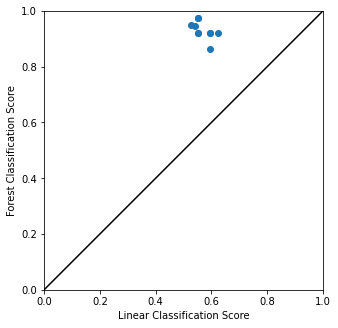

In [25]:
plt.figure(figsize = (5,10))
plt.axes().set_aspect('equal', 'box')#el aspecto
plt.scatter(logistic_regression_scores, forest_classification_scores )#dispersar
plt.plot((0, 1), (0, 1), 'k-')#la linea

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")
plt.show()

Tuning (Ajustar) the Random Forest Classifier

In [26]:
#Arguments

n_estimators=[100,200,300,400,500]
max_features=['auto', 'sqrt']
max_depth = [3,4,5,6,7,8,9,10,11,12,13,14,15, None]
min_samples_split=[2, 5, 10,]
min_samples_leaf=[1, 2, 3]
bootstrap=[True, False]

random_grid_argument = {'n_estimators': n_estimators, 'max_features': max_features, 
               'max_depth': max_depth, 'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

I find the best parameters for the Random Forest Classifier (for a better fit) and the accuracy of the best parameters. Using the **RandomizedSearchCV**.

In [27]:
rf_random = RandomizedSearchCV(estimator=random_forest_cla, param_distributions=random_grid_argument, n_iter =100, cv=3, verbose=2, random_state=1)
rf_random.fit(covariates, classification_outcome)
print(rf_random.best_params_)
print(rf_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=   0.7s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=   0.6s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=   0.6s
[CV] END bootstrap=False, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2

The best parameters is in the arg variable.

In [28]:
arg={'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True}
random_forest_cla=RandomForestClassifier(**arg)

The accuracy of this model is 0.6133.

In [29]:
random_forest_cla.fit(X_train,Y_train)
prediction=random_forest_cla.predict(X_test)
accuracy_score(Y_test,prediction)

0.6133333333333333

##4-Use the classifier for predicting with the test data.

I apply the model.

In [30]:
test_covariates=test_data[all_covariates]
random_forest_cla.fit(covariates,classification_outcome)
label_prediction=random_forest_cla.predict(test_covariates)

In [37]:
test_labels["label"]=label_prediction
test_labels

,Unnamed: 0,timestamp,UTC time,label
0,24339,1565110307041,2019-08-06T16:51:47.041,2
1,24349,1565110308043,2019-08-06T16:51:48.043,2
2,24359,1565110309046,2019-08-06T16:51:49.046,2
3,24369,1565110310048,2019-08-06T16:51:50.048,3
4,24379,1565110311050,2019-08-06T16:51:51.050,2
...,...,...,...,...
120,25539,1565110427366,2019-08-06T16:53:47.366,3
121,25549,1565110428369,2019-08-06T16:53:48.369,3
122,25559,1565110429371,2019-08-06T16:53:49.371,2
123,25569,1565110430373,2019-08-06T16:53:50.373,2


##5-Save the result as CSV and concluding.

Save the result:

In [32]:
test_labels.to_csv('test_labels_submission.csv')

Conclusion:

This is my first project in data analytics, I need more practice. About the data set, it is very simple, and a cell phone can give more data.

In [33]:
#Time calculation
end_time = time.process_time()
elapsed_time = end_time - start_time
print(elapsed_time)

131.12772392000002
